# Joint domain detection for imbalanced dataset

We present our evaluation source code of imbalanced Stereo-seq Slide-seq V2 obtained E9.5 mouse embryo dataset in this section.

## Data Preparation

In [1]:
import numpy as np
import scanpy as sc
import st_datasets as stds
from train_integrate import train_integration

stereo_adata, _ = stds.get_data(stds.get_outside_data, top_genes=8000, 
url='https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/stomics/E9.5_E2S2.MOSTA.h5ad')
slide_adata = sc.read('data/embryo_e9.5_slideseq.h5ad')
slide_adata.var.index = slide_adata.var['features']

sc.pp.highly_variable_genes(slide_adata, flavor="seurat_v3", n_top_genes=8000)
sc.pp.normalize_total(slide_adata, target_sum=1e4)
sc.pp.log1p(slide_adata)

>>> INFO: Use local data.
>>> INFO: dataset name: Outside dataset, size: (4356, 24107), cluster: None.(0.698s)


## Train stMSA

We randomly split the large Slide-seq V2 mouse embryo dataset input two part to train stMSA.

In [2]:
np.random.seed(0)
slide_index = np.arange(slide_adata.shape[0])
np.random.shuffle(slide_index)
slide_p1 = slide_adata[slide_index[: 7000]]
slide_p2 = slide_adata[slide_index[7000:]]

adatas = sc.concat((
    stereo_adata[:, stereo_adata.var['highly_variable']], 
    slide_p1[:, slide_p1.var['highly_variable']],
    slide_p2[:, slide_p2.var['highly_variable']],
), label='batch')
graph = stds.pp.concat_adjacency_matrix(adata_list=[
    stereo_adata, slide_p1, slide_p2
], edge_list=[
    stds.pp.build_graph(stereo_adata, radius=1),
    stds.pp.build_graph(slide_p1, radius=16),
    stds.pp.build_graph(slide_p2, radius=16),
])

adatas = train_integration(adatas, graph=graph)

>>> INFO: Generate 12450 edges, 1.858 edges per spot.(0.147s)
>>> INFO: Generate 17444 edges, 1.492 edges per spot.(0.020s)
>>> INFO: Generate 20896 edges, 1.693 edges per spot.(0.023s)
>>> INFO: Finish generate precluster embedding(7.446s)!


  1%|          | 3/500 [00:02<05:59,  1.38it/s]

>>> INFO: Finish finding mmn pairs, find 503995 mnn node pairs(1.902s)!


 21%|██        | 103/500 [00:12<02:02,  3.24it/s]

>>> INFO: Finish finding mmn pairs, find 673219 mnn node pairs(2.148s)!


 41%|████      | 203/500 [00:22<01:35,  3.12it/s]

>>> INFO: Finish finding mmn pairs, find 812527 mnn node pairs(2.213s)!


 61%|██████    | 303/500 [00:32<01:04,  3.04it/s]

>>> INFO: Finish finding mmn pairs, find 877473 mnn node pairs(2.271s)!


 81%|████████  | 403/500 [00:42<00:32,  3.02it/s]

>>> INFO: Finish finding mmn pairs, find 909429 mnn node pairs(2.271s)!


100%|██████████| 500/500 [00:50<00:00,  9.83it/s]


## Visualization

We use `UMAP` to evaluate the batch-effect elimination performance and use `louvain` for spatial domain identification.

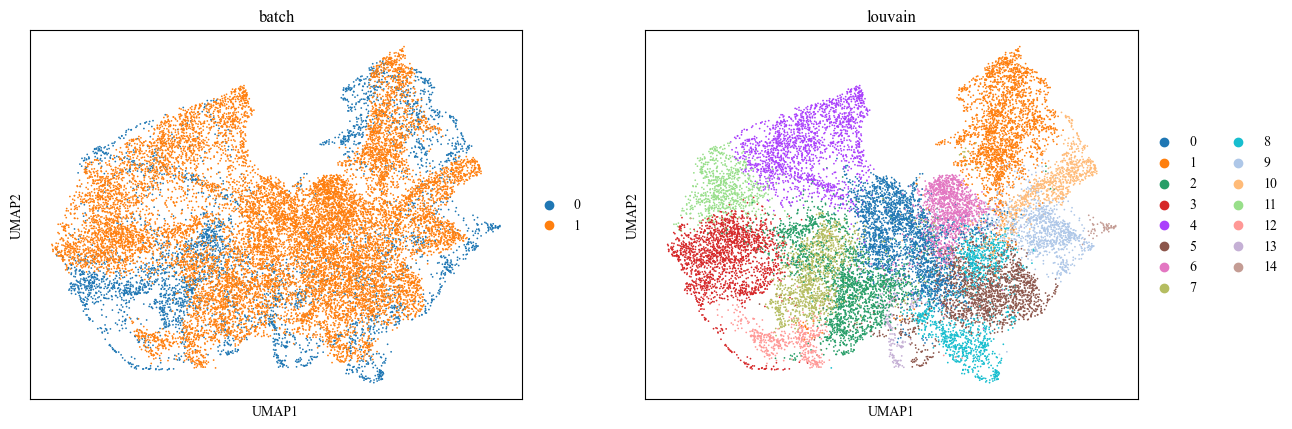

In [3]:
sc.pp.neighbors(adatas, use_rep='embedding')
sc.tl.louvain(adatas, resolution=0.8)

sc.tl.umap(adatas)
adatas.obs['batch'] = np.where('0' == adatas.obs['batch'], '0', '1')
sc.pl.umap(adatas, color=['batch', 'louvain'])